In [1]:
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import argparse
import os
import time
from tqdm import tqdm
import numpy as np
import yaml

In [2]:
class RandomGraph(object):
    def __init__(self, node_num, p, k=4, m=5, graph_mode="ER"):
        self.node_num = node_num
        self.p = p
        self.k = k
        self.m = m
        self.graph_mode = graph_mode

    def make_graph(self):
        
        # reference
        # https://networkx.github.io/documentation/networkx-1.9/reference/generators.html
        if self.graph_mode == "ER":
            graph = nx.random_graphs.erdos_renyi_graph(self.node_num, self.p)
        elif self.graph_mode == "WS":
            graph = nx.random_graphs.watts_strogatz_graph(self.node_num, self.k, self.p)
        elif self.graph_mode == "BA":
            graph = nx.random_graphs.barabasi_albert_graph(self.node_num, self.m)

        return graph

    def get_graph_info(self, graph):
        in_edges = {}
        in_edges[0] = []
        nodes = [0]
        end = []
        for node in graph.nodes():
            neighbors = list(graph.neighbors(node))
            neighbors.sort()

            edges = []
            check = []
            for neighbor in neighbors:
                if node > neighbor:
                    edges.append(neighbor + 1)
                    check.append(neighbor)
            if not edges:
                edges.append(0)
            in_edges[node + 1] = edges
            if check == neighbors:
                end.append(node + 1)
            nodes.append(node + 1)
        in_edges[self.node_num + 1] = end
        nodes.append(self.node_num + 1)

        return nodes, in_edges

    def save_random_graph(self, graph, path):
        if not os.path.isdir("saved_graph"):
            os.mkdir("saved_graph")
        with open('./saved_graph/' + path, 'w') as f:
            yaml.dump(graph, f)
        #nx.write_yaml(graph, "./saved_graph/" + path)

    def load_random_graph(self, path):
        #return nx.read_yaml("./saved_graph/" + path)
        with open("./saved_graph/" + path, 'r') as f:
            G = yaml.load(f, Loader=yaml.loader)
        return G

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
#reference
# https://github.com/tstandley/Xception-PyTorch/blob/master/xception.py
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=True):
        super(SeparableConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

        # self.apply(weights_init)

    def forward(self, x):
        x = self.conv(x)
        x = self.pointwise(x)
        return x


# ReLU-convolution-BN triplet
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Unit, self).__init__()

        self.dropout_rate = 0.2

        self.unit = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(self.dropout_rate)
        )

    def forward(self, x):
        return self.unit(x)


# The paper announced "The aggregation is done by weighted sum with learnable positive weights".
class Node(nn.Module):
    def __init__(self, in_degree, in_channels, out_channels, stride=1):
        super(Node, self).__init__()
        self.in_degree = in_degree
        if len(self.in_degree) > 1:
            # self.weights = nn.Parameter(torch.zeros(len(self.in_degree), requires_grad=True))
            self.weights = nn.Parameter(torch.ones(len(self.in_degree), requires_grad=True))
        self.unit = Unit(in_channels, out_channels, stride=stride)

    def forward(self, *input):
        if len(self.in_degree) > 1:
            x = (input[0] * torch.sigmoid(self.weights[0]))
            for index in range(1, len(input)):
                x += (input[index] * torch.sigmoid(self.weights[index]))
            out = self.unit(x)

            # different paper, add identity mapping
            # out += x
        else:
            out = self.unit(input[0])
        return out


class RandWire(nn.Module):
    def __init__(self, node_num, p, in_channels, out_channels, graph_mode, is_train, name):
        super(RandWire, self).__init__()
        self.node_num = node_num
        self.p = p
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.graph_mode = graph_mode
        self.is_train = is_train
        self.name = name

        # get graph nodes and in edges
        graph_node = RandomGraph(self.node_num, self.p, graph_mode=graph_mode)
        if self.is_train:
            graph = graph_node.make_graph()
            self.nodes, self.in_edges = graph_node.get_graph_info(graph)
            graph_node.save_random_graph(graph, name)
        else:
            graph = graph_node.load_random_graph(name)
            self.nodes, self.in_edges = graph_node.get_graph_info(graph)

        # define input Node
        self.module_list = nn.ModuleList([Node(self.in_edges[0], self.in_channels, self.out_channels, stride=2)])
        # define the rest Node
        self.module_list.extend([Node(self.in_edges[node], self.out_channels, self.out_channels) for node in self.nodes if node > 0])

    def forward(self, x):
        memory = {}
        # start vertex
        out = self.module_list[0].forward(x)
        memory[0] = out

        # the rest vertex
        for node in range(1, len(self.nodes) - 1):
            # print(node, self.in_edges[node][0], self.in_edges[node])
            if len(self.in_edges[node]) > 1:
                out = self.module_list[node].forward(*[memory[in_vertex] for in_vertex in self.in_edges[node]])
            else:
                out = self.module_list[node].forward(memory[self.in_edges[node][0]])
            memory[node] = out
        out = memory[self.in_edges[self.node_num + 1][0]]
        for in_vertex_index in range(1, len(self.in_edges[self.node_num + 1])):
            out += memory[self.in_edges[self.node_num + 1][in_vertex_index]]
        out = out / len(self.in_edges[self.node_num + 1])
        return out


In [4]:
class Model(nn.Module):
    def __init__(self, node_num, p, in_channels, out_channels, graph_mode, model_mode, dataset_mode, is_train):
        super(Model, self).__init__()
        self.node_num = node_num
        self.p = p
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.graph_mode = graph_mode
        self.model_mode = model_mode
        self.is_train = is_train
        self.dataset_mode = dataset_mode

        self.num_classes = 1000
        self.dropout_rate = 0.2

        if self.dataset_mode == "CIFAR10":
            self.num_classes = 10
        elif self.dataset_mode == "CIFAR100":
            self.num_classes = 100
        elif self.dataset_mode == "IMAGENET":
            self.num_classes = 1000
        elif self.dataset_mode == "MNIST":
            self.num_classes = 10

        if self.model_mode == "CIFAR10":
            self.CIFAR_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.out_channels),
            )

            self.CIFAR_conv2 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels, self.graph_mode, self.is_train, name="CIFAR_conv2")
            )
            self.CIFAR_conv3 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels * 2, self.graph_mode, self.is_train, name="CIFAR_conv3")
            )
            self.CIFAR_conv4 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 2, self.out_channels * 4, self.graph_mode, self.is_train, name="CIFAR_conv4")
            )

            self.CIFAR_classifier = nn.Sequential(
                nn.Conv2d(self.in_channels * 4, 1280, kernel_size=1),
                nn.BatchNorm2d(1280)
            )
        elif self.model_mode == "CIFAR100":
            self.CIFAR100_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=self.out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.out_channels),
            )

            self.CIFAR100_conv2 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels * 2, self.graph_mode, self.is_train, name="CIFAR100_conv2")
            )
            self.CIFAR100_conv3 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 2, self.out_channels * 4, self.graph_mode, self.is_train, name="CIFAR100_conv3")
            )
            self.CIFAR100_conv4 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 4, self.out_channels * 8, self.graph_mode, self.is_train, name="CIFAR100_conv4")
            )

            self.CIFAR100_classifier = nn.Sequential(
                nn.Conv2d(self.in_channels * 8, 1280, kernel_size=1),
                nn.BatchNorm2d(1280)
            )
        elif self.model_mode == "SMALL_REGIME":
            self.SMALL_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=self.out_channels // 2, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.out_channels // 2),
                nn.ReLU()
            )
            self.SMALL_conv2 = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels // 2, out_channels=self.out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.out_channels)
            )
            self.SMALL_conv3 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels, self.graph_mode, self.is_train, name="SMALL_conv3")
            )
            self.SMALL_conv4 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels * 2, self.graph_mode, self.is_train, name="SMALL_conv4")
            )
            self.SMALL_conv5 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 2, self.out_channels * 4, self.graph_mode, self.is_train, name="SMALL_conv5")
            )
            self.SMALL_classifier = nn.Sequential(
                nn.Conv2d(self.in_channels * 4, 1280, kernel_size=1),
                nn.BatchNorm2d(1280)
            )
        elif self.model_mode == "REGULAR_REGIME":
            self.REGULAR_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=self.out_channels // 2, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.out_channels // 2)
            )
            self.REGULAR_conv2 = nn.Sequential(
                RandWire(self.node_num // 2, self.p, self.in_channels // 2, self.out_channels, self.graph_mode, self.is_train, name="REGULAR_conv2")
            )
            self.REGULAR_conv3 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels, self.out_channels * 2, self.graph_mode, self.is_train, name="REGULAR_conv3")
            )
            self.REGULAR_conv4 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 2, self.out_channels * 4, self.graph_mode, self.is_train, name="REGULAR_conv4")
            )
            self.REGULAR_conv5 = nn.Sequential(
                RandWire(self.node_num, self.p, self.in_channels * 4, self.out_channels * 8, self.graph_mode, self.is_train, name="REGULAR_conv5")
            )
            self.REGULAR_classifier = nn.Sequential(
                nn.Conv2d(self.in_channels * 8, 1280, kernel_size=1),
                nn.BatchNorm2d(1280)
            )

        self.output = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(1280, self.num_classes)
        )

    def forward(self, x):
        if self.model_mode == "CIFAR10":
            out = self.CIFAR_conv1(x)
            out = self.CIFAR_conv2(out)
            out = self.CIFAR_conv3(out)
            out = self.CIFAR_conv4(out)
            out = self.CIFAR_classifier(out)
        elif self.model_mode == "CIFAR100":
            out = self.CIFAR100_conv1(x)
            out = self.CIFAR100_conv2(out)
            out = self.CIFAR100_conv3(out)
            out = self.CIFAR100_conv4(out)
            out = self.CIFAR100_classifier(out)
        elif self.model_mode == "SMALL_REGIME":
            out = self.SMALL_conv1(x)
            out = self.SMALL_conv2(out)
            out = self.SMALL_conv3(out)
            out = self.SMALL_conv4(out)
            out = self.SMALL_conv5(out)
            out = self.SMALL_classifier(out)
        elif self.model_mode == "REGULAR_REGIME":
            out = self.REGULAR_conv1(x)
            out = self.REGULAR_conv2(out)
            out = self.REGULAR_conv3(out)
            out = self.REGULAR_conv4(out)
            out = self.REGULAR_conv5(out)
            out = self.REGULAR_classifier(out)

        # global average pooling
        out = F.avg_pool2d(out, kernel_size=out.size()[2:])
        out = torch.squeeze(out)
        out = self.output(out)

        return out

In [5]:
from torchvision import datasets, transforms


# CIFAR-10,
# mean, [0.4914, 0.4822, 0.4465]
# std, [0.2470, 0.2435, 0.2616]
# CIFAR-100,
# mean, [0.5071, 0.4865, 0.4409]
# std, [0.2673, 0.2564, 0.2762]
def load_data(args):
    if args.dataset_mode == "CIFAR10":
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True, transform=transform_train),
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=2
        )

        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, transform=transform_test),
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=2
        )
    elif args.dataset_mode == "CIFAR100":
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        ])
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data', train=True, download=True, transform=transform_train),
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=2
        )

        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data', train=False, transform=transform_test),
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=2
        )
    elif args.dataset_mode == "MNIST":
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data', train=True, download=True, transform=transform_train),
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=2
        )

        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('data', train=False, transform=transform_test),
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=2
        )

    return train_loader, test_loader

In [6]:
import matplotlib.pyplot as plt

def draw_plot(epoch_list, train_loss_list, train_acc_list, val_acc_list):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(epoch_list, train_loss_list, label='training loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epoch_list, train_acc_list, label='train acc')
    plt.plot(epoch_list, val_acc_list, label='validation acc')
    plt.legend()

    if os.path.isdir('./plot'):
        plt.savefig('./plot/epoch_acc_plot.png')

    else:
        os.makedirs('./plot')
        plt.savefig('./plot/epoch_acc_plot.png')
    plt.close()

In [7]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.learning_rate * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


test_acc_list = []
train_acc_list = []
train_loss_list = []

def train(model, train_loader, optimizer, criterion, epoch, args):
    model.train()
    step = 0
    train_loss = 0
    train_acc = 0
    for data, target in tqdm(train_loader, desc="epoch " + str(epoch), mininterval=1):
        adjust_learning_rate(optimizer, epoch, args)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        y_pred = output.data.max(1)[1]

        acc = float(y_pred.eq(target.data).sum()) / len(data) * 100.
        train_acc += acc
        step += 1
        if step % 100 == 0:
            print("[Epoch {0:4d}] Loss: {1:2.3f} Acc: {2:.3f}%".format(epoch, loss.data, acc), end='')
            for param_group in optimizer.param_groups:
                print("  Current learning rate is: {}".format(param_group['lr']))

    length = len(train_loader.dataset) // args.batch_size
    return train_loss / length, train_acc / length


def test(model, test_loader):
    model.eval()
    correct = 0
    for data, target in tqdm(test_loader, desc="evaluation", mininterval=1):
        data, target = data.to(device), target.to(device)
        output = model(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()

    acc = 100. * float(correct) / len(test_loader.dataset)
    return acc


def main():
    parser = argparse.ArgumentParser('parameters')

    parser.add_argument('--epochs', type=int, default=20, help='number of epochs, (default: 20)')
    parser.add_argument('--p', type=float, default=0.75, help='graph probability, (default: 0.75)')
    parser.add_argument('--c', type=int, default=78, help='channel count for each node, 109, 154 (default: 154)')
    parser.add_argument('--k', type=int, default=4, help='each node is connected to k nearest neighbors in ring topology, (default: 4)')
    parser.add_argument('--m', type=int, default=5, help='number of edges to attach from a new node to existing nodes, (default: 5)')
    parser.add_argument('--graph-mode', type=str, default="BA", help="random graph, (Example: ER, WS, BA), (default: WS)")
    parser.add_argument('--node-num', type=int, default=32, help="Number of graph node (default n=32)")
    parser.add_argument('--learning-rate', type=float, default=1e-1, help='learning rate, (default: 1e-1)')
    parser.add_argument('--batch-size', type=int, default=100, help='batch size, (default: 100)')
    parser.add_argument('--model-mode', type=str, default="CIFAR10", help='CIFAR10, CIFAR100, SMALL_REGIME, REGULAR_REGIME, (default: CIFAR10)')
    parser.add_argument('--dataset-mode', type=str, default="CIFAR10", help='Which dataset to use? (Example, CIFAR10, CIFAR100, MNIST), (default: CIFAR10)')
    parser.add_argument('--load-model', type=bool, default=False)
    parser.add_argument('--is-train', type=bool, default=True)

    args = parser.parse_args([])

    train_loader, test_loader = load_data(args)

    if args.load_model:
        model = Model(args.node_num, args.p, args.c, args.c, args.graph_mode, args.model_mode, args.dataset_mode, args.is_train).to(device)
        filename = "c_" + str(args.c) + "_p_" + str(args.p) + "_graph_mode_" + args.graph_mode + "_dataset_" + args.dataset_mode
        checkpoint = torch.load('./checkpoint/' + filename + 'ckpt.t7')
        model.load_state_dict(checkpoint['model'])
        epoch = checkpoint['epoch']
        acc = checkpoint['acc']
        print("Load Model Accuracy: ", acc, "Load Model end epoch: ", epoch)
    else:
        model = Model(args.node_num, args.p, args.c, args.c, args.graph_mode, args.model_mode, args.dataset_mode, args.is_train).to(device)

    optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, weight_decay=5e-4, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to(device)

    epoch_list = []
    max_test_acc = 0
    if not os.path.isdir("reporting"):
        os.mkdir("reporting")

    start_time = time.time()
    with open("./reporting/" + "c_" + str(args.c) + "_p_" + str(args.p) + "_graph_mode_" + args.graph_mode + "_dataset_" + args.dataset_mode + ".txt", "w") as f:
        for epoch in range(1, args.epochs + 1):
            # scheduler = CosineAnnealingLR(optimizer, epoch)
            epoch_list.append(epoch)
            train_loss, train_acc = train(model , train_loader, optimizer, criterion, epoch, args)
            test_acc = test(model, test_loader)
            test_acc_list.append(test_acc)
            train_loss_list.append(train_loss.cpu())
            train_acc_list.append(train_acc)
            print('Test set accuracy: {0:.3f}%'.format(test_acc))
            f.write("[Epoch {0:3d}] Test set accuracy: {1:.3f}%".format(epoch, test_acc))
            f.write("\n ")

            if max_test_acc < test_acc:
                print('Saving..')
                state = {
                    'model': model.state_dict(),
                    'acc': test_acc,
                    'epoch': epoch,
                }
                if not os.path.isdir('checkpoint'):
                    os.mkdir('checkpoint')
                filename = "c_" + str(args.c) + "_p_" + str(
                    args.p) + "_graph_mode_" + args.graph_mode + "_dataset_" + args.dataset_mode
                torch.save(state, './checkpoint/' + filename + 'ckpt.t7')
                max_test_acc = test_acc
                draw_plot(epoch_list, train_loss_list, train_acc_list, test_acc_list)
            print("Training time: ", time.time() - start_time)
            f.write("Training time: " + str(time.time() - start_time))
            f.write("\n")


if __name__ == '__main__':
    main()


Files already downloaded and verified


epoch 1:  19%|█████████████▉                                                          | 97/500 [00:18<01:09,  5.82it/s]

[Epoch    1] Loss: 1.890 Acc: 27.000%  Current learning rate is: 0.1


epoch 1:  40%|████████████████████████████▎                                          | 199/500 [00:36<00:52,  5.76it/s]

[Epoch    1] Loss: 1.885 Acc: 36.000%  Current learning rate is: 0.1


epoch 1:  60%|██████████████████████████████████████████▋                            | 301/500 [00:53<00:33,  5.91it/s]

[Epoch    1] Loss: 1.607 Acc: 43.000%  Current learning rate is: 0.1


epoch 1:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:10<00:17,  5.84it/s]

[Epoch    1] Loss: 1.548 Acc: 46.000%  Current learning rate is: 0.1


epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:27<00:00,  5.69it/s]


[Epoch    1] Loss: 1.550 Acc: 45.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.26it/s]


Test set accuracy: 41.640%
Saving..
Training time:  93.90887880325317


epoch 2:  19%|█████████████▉                                                          | 97/500 [00:19<01:08,  5.87it/s]

[Epoch    2] Loss: 1.520 Acc: 42.000%  Current learning rate is: 0.1


epoch 2:  40%|████████████████████████████▍                                          | 200/500 [00:36<00:50,  5.93it/s]

[Epoch    2] Loss: 1.192 Acc: 54.000%  Current learning rate is: 0.1


epoch 2:  59%|██████████████████████████████████████████▏                            | 297/500 [00:53<00:34,  5.92it/s]

[Epoch    2] Loss: 1.297 Acc: 56.000%  Current learning rate is: 0.1


epoch 2:  80%|████████████████████████████████████████████████████████▉              | 401/500 [01:11<00:17,  5.82it/s]

[Epoch    2] Loss: 1.409 Acc: 47.000%  Current learning rate is: 0.1


epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.68it/s]


[Epoch    2] Loss: 1.293 Acc: 54.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.28it/s]


Test set accuracy: 53.150%
Saving..
Training time:  188.29803848266602


epoch 3:  20%|██████████████▎                                                         | 99/500 [00:19<01:09,  5.77it/s]

[Epoch    3] Loss: 1.164 Acc: 58.000%  Current learning rate is: 0.1


epoch 3:  40%|████████████████████████████▌                                          | 201/500 [00:37<00:51,  5.81it/s]

[Epoch    3] Loss: 1.135 Acc: 54.000%  Current learning rate is: 0.1


epoch 3:  59%|██████████████████████████████████████████▏                            | 297/500 [00:53<00:35,  5.79it/s]

[Epoch    3] Loss: 1.154 Acc: 56.000%  Current learning rate is: 0.1


epoch 3:  80%|████████████████████████████████████████████████████████▉              | 401/500 [01:11<00:17,  5.75it/s]

[Epoch    3] Loss: 1.046 Acc: 60.000%  Current learning rate is: 0.1


epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.62it/s]


[Epoch    3] Loss: 1.046 Acc: 64.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.01it/s]


Test set accuracy: 55.080%
Saving..
Training time:  283.24726486206055


epoch 4:  20%|██████████████                                                          | 98/500 [00:19<01:08,  5.90it/s]

[Epoch    4] Loss: 0.890 Acc: 69.000%  Current learning rate is: 0.1


epoch 4:  40%|████████████████████████████▍                                          | 200/500 [00:36<00:51,  5.83it/s]

[Epoch    4] Loss: 1.268 Acc: 51.000%  Current learning rate is: 0.1


epoch 4:  59%|██████████████████████████████████████████                             | 296/500 [00:53<00:34,  5.83it/s]

[Epoch    4] Loss: 1.044 Acc: 61.000%  Current learning rate is: 0.1


epoch 4:  80%|████████████████████████████████████████████████████████▌              | 398/500 [01:11<00:17,  5.83it/s]

[Epoch    4] Loss: 0.869 Acc: 72.000%  Current learning rate is: 0.1


epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.65it/s]


[Epoch    4] Loss: 0.853 Acc: 71.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.99it/s]


Test set accuracy: 66.300%
Saving..
Training time:  377.86622762680054


epoch 5:  19%|█████████████▉                                                          | 97/500 [00:19<01:08,  5.85it/s]

[Epoch    5] Loss: 1.048 Acc: 65.000%  Current learning rate is: 0.1


epoch 5:  40%|████████████████████████████▎                                          | 199/500 [00:36<00:51,  5.87it/s]

[Epoch    5] Loss: 1.188 Acc: 54.000%  Current learning rate is: 0.1


epoch 5:  60%|██████████████████████████████████████████▋                            | 301/500 [00:54<00:34,  5.83it/s]

[Epoch    5] Loss: 1.002 Acc: 64.000%  Current learning rate is: 0.1


epoch 5:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:10<00:17,  5.86it/s]

[Epoch    5] Loss: 0.915 Acc: 70.000%  Current learning rate is: 0.1


epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.63it/s]


[Epoch    5] Loss: 0.827 Acc: 70.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.09it/s]


Test set accuracy: 62.800%
Training time:  472.92651295661926


epoch 6:  19%|█████████████▉                                                          | 97/500 [00:19<01:10,  5.73it/s]

[Epoch    6] Loss: 0.886 Acc: 73.000%  Current learning rate is: 0.1


epoch 6:  40%|████████████████████████████▎                                          | 199/500 [00:37<00:52,  5.74it/s]

[Epoch    6] Loss: 0.997 Acc: 65.000%  Current learning rate is: 0.1


epoch 6:  60%|██████████████████████████████████████████▋                            | 301/500 [00:54<00:34,  5.73it/s]

[Epoch    6] Loss: 0.908 Acc: 70.000%  Current learning rate is: 0.1


epoch 6:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:11<00:17,  5.76it/s]

[Epoch    6] Loss: 0.804 Acc: 73.000%  Current learning rate is: 0.1


epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]


[Epoch    6] Loss: 0.746 Acc: 72.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.33it/s]


Test set accuracy: 69.640%
Saving..
Training time:  568.4811627864838


epoch 7:  19%|█████████████▉                                                          | 97/500 [00:19<01:10,  5.75it/s]

[Epoch    7] Loss: 0.897 Acc: 66.000%  Current learning rate is: 0.1


epoch 7:  40%|████████████████████████████▎                                          | 199/500 [00:37<00:52,  5.78it/s]

[Epoch    7] Loss: 0.731 Acc: 74.000%  Current learning rate is: 0.1


epoch 7:  60%|██████████████████████████████████████████▋                            | 301/500 [00:54<00:34,  5.80it/s]

[Epoch    7] Loss: 1.011 Acc: 67.000%  Current learning rate is: 0.1


epoch 7:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:11<00:17,  5.76it/s]

[Epoch    7] Loss: 0.829 Acc: 70.000%  Current learning rate is: 0.1


epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.61it/s]


[Epoch    7] Loss: 0.904 Acc: 65.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.77it/s]


Test set accuracy: 66.420%
Training time:  663.9804215431213


epoch 8:  19%|█████████████▉                                                          | 97/500 [00:19<01:09,  5.79it/s]

[Epoch    8] Loss: 0.884 Acc: 69.000%  Current learning rate is: 0.1


epoch 8:  40%|████████████████████████████▎                                          | 199/500 [00:36<00:52,  5.75it/s]

[Epoch    8] Loss: 0.813 Acc: 71.000%  Current learning rate is: 0.1


epoch 8:  60%|██████████████████████████████████████████▋                            | 301/500 [00:54<00:34,  5.77it/s]

[Epoch    8] Loss: 0.791 Acc: 70.000%  Current learning rate is: 0.1


epoch 8:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:11<00:17,  5.81it/s]

[Epoch    8] Loss: 0.752 Acc: 77.000%  Current learning rate is: 0.1


epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]


[Epoch    8] Loss: 0.964 Acc: 67.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.99it/s]


Test set accuracy: 71.400%
Saving..
Training time:  759.7576265335083


epoch 9:  19%|█████████████▉                                                          | 97/500 [00:19<01:10,  5.73it/s]

[Epoch    9] Loss: 0.631 Acc: 77.000%  Current learning rate is: 0.1


epoch 9:  40%|████████████████████████████▎                                          | 199/500 [00:37<00:51,  5.83it/s]

[Epoch    9] Loss: 0.968 Acc: 69.000%  Current learning rate is: 0.1


epoch 9:  60%|██████████████████████████████████████████▋                            | 301/500 [00:54<00:34,  5.79it/s]

[Epoch    9] Loss: 0.824 Acc: 70.000%  Current learning rate is: 0.1


epoch 9:  79%|████████████████████████████████████████████████████████▎              | 397/500 [01:11<00:17,  5.78it/s]

[Epoch    9] Loss: 0.798 Acc: 72.000%  Current learning rate is: 0.1


epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s]


[Epoch    9] Loss: 0.874 Acc: 69.000%  Current learning rate is: 0.1


evaluation: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.46it/s]


Test set accuracy: 70.060%
Training time:  855.1209456920624


epoch 10:  19%|█████████████▊                                                         | 97/500 [00:19<01:09,  5.81it/s]

[Epoch   10] Loss: 0.741 Acc: 76.000%  Current learning rate is: 0.1


epoch 10:  24%|████████████████▉                                                     | 121/500 [00:23<01:06,  5.69it/s]

In [12]:
def showlss(running_loss):
    # generate x value
    x = np.array([i for i in range(len(running_loss))])
    # generate y value
    y = np.array(running_loss)
    # define a graph
    plt.figure()
    # generate curve
    plt.plot(x, y, c='b')
    # show axis
    plt.axis()
    # define title
    plt.title('loss curve:')
    #define the name of x axis
    plt.xlabel('step')
    plt.ylabel('loss value')
    # show graph
    plt.show()
    
def showacc(running_accuracy):
    x = np.array([i for i in range(len(running_accuracy))])
    y = np.array(running_accuracy)
    plt.figure()
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('accuracy curve:')
    plt.xlabel('step')
    plt.ylabel('accuracy value')
    plt.show()

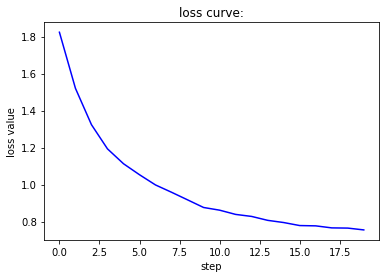

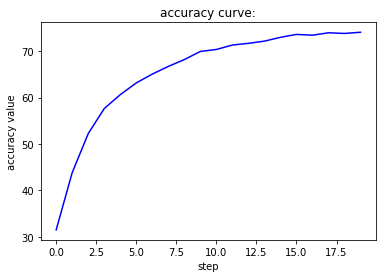

In [13]:
showlss(train_loss_list)
showacc(train_acc_list)

In [35]:

    train_acc_list = []
    train_loss_list = []